In [190]:
# Victor Z and Ugochukwu Ikegwu
# UW-Madison, 2024
# Gaussian process (kriging) prediction for gibbs data

## Start here if working on google collab

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [192]:
# Specify the path of this file (This may differ for each user)
path = '/content/drive/MyDrive/StatsBookCode/Python/'

In [193]:
# This is to check if the speficied path above is correct
!echo $path
import os
os.path.isdir(path)

/content/drive/MyDrive/StatsBookCode/Python/


True

In [194]:
# This is needed so we can import packages from a different path than standard libraries
import sys
sys.path.append(path)

## Start from here if working on local computer

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import gaussian_process as gpr
from sklearn.linear_model import LinearRegression

In [196]:
# Load data
filename = path+'Data/gibbs_hightemp_class.dat'
# read text file into pandas DataFrame
datahigh = pd.read_csv(filename, sep="\t", header=None)
datahigh.head(5)

,0,1,2
0,613.15,166.977686,0.536382
1,613.15,170.710337,0.546996
2,613.15,141.174815,0.455329
3,613.15,146.628653,0.473593
4,613.15,164.665427,0.529668


In [197]:
# Load data
filename = path+'Data/gibbs_lowtemp_class.dat'
# read text file into pandas DataFrame
datalow = pd.read_csv(filename, sep="\t", header=None)
datalow.head(5)

,0,1,2
0,583.15,166.977686,0.744386
1,583.15,170.710337,0.752465
2,583.15,141.174815,0.677784
3,583.15,146.628653,0.693596
4,583.15,164.665427,0.739204


In [198]:
# Concatenate both tables
data = pd.concat([datahigh, datalow])
datan = data.copy()
n = len(datan)

In [199]:
np.random.seed(1) # to ensure reproducibility

# Generate inputs (temperature and pressure) with random noise
inputs = data.iloc[:, :2].T + np.random.rand(2, n) * 0.1

# Generate targets (yield) with random noise
targets = data.iloc[:, 2].T + np.random.rand(n) * 0.1

In [200]:
# Define kriging model
kernel = gpr.kernels.Matern(length_scale = 1, nu = 1.5)
gprMdl = gpr.GaussianProcessRegressor(kernel = kernel,
                                      normalize_y = True,
                                      n_restarts_optimizer = 10)
gprMdl.fit(inputs.T, targets)

# Predict outputs
outputsgpr = gprMdl.predict(inputs.T)
eps = targets - outputsgpr

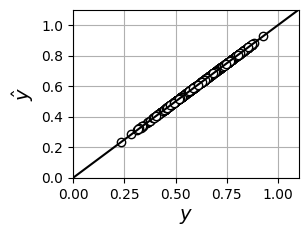

In [201]:
# Plot fit
plt.figure(1)
plt.subplot(2, 2, 1)
xx = np.linspace(0, 1.1)
plt.plot(targets, outputsgpr, 'ko', markerfacecolor='w')
plt.grid(True)
plt.plot(xx, xx, 'k-')
plt.xlabel('$y$', fontsize=14)
plt.ylabel('$\hat{y}$', fontsize=14)
plt.axis([0, 1.1, 0, 1.1])
plt.show()

In [202]:
# Define linear regression model
mdl = LinearRegression()
mdl.fit(inputs.T, targets)

# Predict outputs
outputsLR = mdl.predict(inputs.T)
eps2 = targets - outputsLR

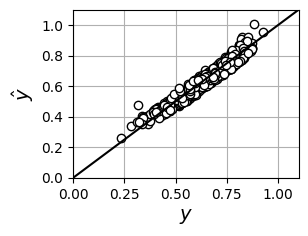

In [203]:
# Plot fit
plt.figure(1)
plt.subplot(2, 2, 2)
xx = np.linspace(0, 1.1)
plt.plot(targets, outputsLR, 'ko', markerfacecolor='w')
plt.grid(True)
plt.plot(xx, xx, 'k-')
plt.xlabel('$y$', fontsize=14)
plt.ylabel('$\hat{y}$', fontsize=14)
plt.axis([0, 1.1, 0, 1.1])
plt.show()

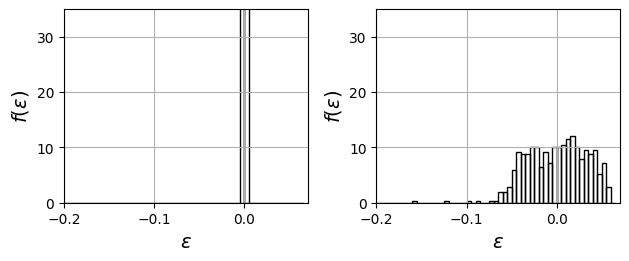

In [204]:
# Compare benchmarks using CDFs and PDFs of residuals
plt.figure(3)

# Plot histogram of residuals for model with Gaussian Process Regression
plt.subplot(2, 2, 1)
plt.hist(eps, bins=np.arange(-0.2, 0.07, 0.005), density=True, edgecolor='black', facecolor='none', linewidth=1)
plt.grid(True)
plt.xlabel('$\epsilon$', fontsize=14)
plt.ylabel('$f(\epsilon)$', fontsize=14)
plt.axis([-0.2, 0.07, 0, 35])

# Plot histogram of residuals for model with Linear Regression
plt.subplot(2, 2, 2)
plt.hist(eps2, bins=np.arange(-0.2, 0.07, 0.005), density=True, edgecolor='black', facecolor='none', linewidth=1)
plt.grid(True)
plt.xlabel('$\epsilon$', fontsize=14)
plt.ylabel('$f(\epsilon)$', fontsize=14)
plt.axis([-0.2, 0.07, 0, 35])

plt.tight_layout()
plt.show()


In [205]:
# Compute ECDFs of absolute residuals
F1, X1 = np.histogram(np.abs(eps), bins=np.linspace(0, 0.1, 100), density=True)
F1 = np.cumsum(F1) * np.diff(X1)
F2, X2 = np.histogram(np.abs(eps2), bins=np.linspace(0, 0.1, 100), density=True)
F2 = np.cumsum(F2) * np.diff(X2)

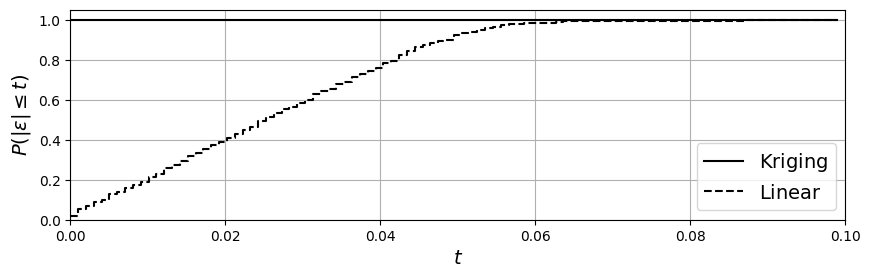

In [206]:
# Plot ECDFs
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 2)
plt.step(X1[:-1], F1, 'k-', linewidth=1.5, where='post', label='$\mathrm{Kriging}$')
plt.step(X2[:-1], F2, 'k--', linewidth=1.5, where='post', label='$\mathrm{Linear}$')
plt.grid(True)
plt.axis([0, 0.1, 0, 1.05])
plt.xlabel('$t$', fontsize=14)
plt.ylabel('$P(|\epsilon|\leq t)$', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [207]:
# Assuming gprMdl is the trained Gaussian Process Regression model
outputsgpr, outputsd = gprMdl.predict(inputs.T, return_std=True)
outputsci = np.column_stack((outputsgpr - 1.96 * outputsd, outputsgpr + 1.96 * outputsd))

# Extract confidence intervals for GPR
c1 = outputsci[:, 0]
c2 = outputsci[:, 1]
E = (c2 - c1) / 2

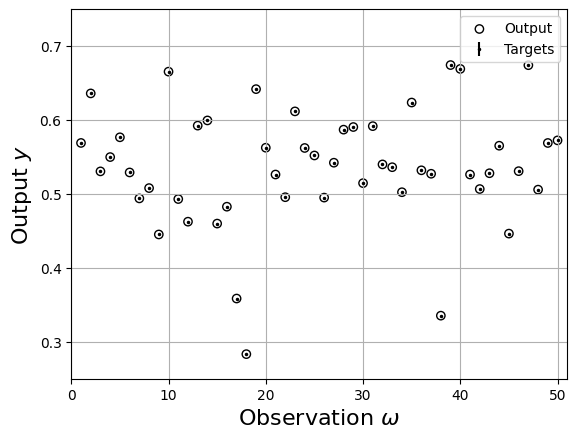

In [208]:
# Plot confidence intervals for GPR
plt.figure(4)
plt.errorbar(np.arange(1, 51), targets[:50], yerr=E[:50], fmt='k.', markersize=3, label='Targets')
plt.scatter(np.arange(1, 51), outputsgpr[:50], color='black', marker='o', facecolors='none', label='Output')
plt.axis([0, 51, 0.25, 0.75])
plt.xlabel('Observation $\omega$', fontsize=16)
plt.ylabel('Output $y$', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()